In [1]:
### Imports

import pandas as pd
import numpy as np

from datetime import datetime, timedelta

import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature

### 1. Data manipulation and cleaning

In [2]:
### Load the data
### Best strategy seems to be using the time series representation of confirmed/died/recovered

confirmed = pd.read_csv('data/time_series_19-covid-Confirmed.csv')
deaths = pd.read_csv('data/time_series_19-covid-Deaths.csv')
recovered = pd.read_csv('data/time_series_19-covid-Recovered.csv')

populations = pd.read_csv('data/population-figures-by-country-csv_csv.csv')

country_codes = pd.read_csv('data/country_codes.csv')

Examining the structure of our data; we have a wide form table with daily reported case numbers for each country, some divided by region. Each of tables are structured in the same way.

In [3]:
confirmed.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/10/2020,3/11/2020,3/12/2020,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20
0,NaN,Thailand,15.0000,101.0000,2,3,5,7,8,8,...,53,59,70,75,82,114,147,177,212,272
1,NaN,Japan,36.0000,138.0000,2,1,2,2,4,4,...,581,639,639,701,773,839,825,878,889,924
2,NaN,Singapore,1.2833,103.8333,0,1,3,3,4,5,...,160,178,178,200,212,226,243,266,313,345
3,NaN,Nepal,28.1667,84.2500,0,0,0,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,NaN,Malaysia,2.5000,112.5000,0,0,0,3,4,4,...,129,149,149,197,238,428,566,673,790,900


In [4]:
deaths.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20
0,NaN,Thailand,15.0000,101.0000,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
1,NaN,Japan,36.0000,138.0000,0,0,0,0,0,0,...,10,15,16,19,22,22,27,29,29,29
2,NaN,Singapore,1.2833,103.8333,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,NaN,Nepal,28.1667,84.2500,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,NaN,Malaysia,2.5000,112.5000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,2,2


In [5]:
recovered.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20
0,NaN,Thailand,15.0000,101.0000,0,0,0,0,2,2,...,33,34,34,35,35,35,35,41,42,42
1,NaN,Japan,36.0000,138.0000,0,0,0,0,1,1,...,101,118,118,118,118,118,144,144,144,150
2,NaN,Singapore,1.2833,103.8333,0,0,0,0,0,0,...,78,96,96,97,105,105,109,114,114,114
3,NaN,Nepal,28.1667,84.2500,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
4,NaN,Malaysia,2.5000,112.5000,0,0,0,0,0,0,...,24,26,26,26,35,42,42,49,60,75


confirmed[confirmed['Province/State'] == 'United Kingdom'][['Lat', 'Long']]confirmed[confirmed['Province/State'] == 'United Kingdom'][['Lat', 'Long']]At this stage, we are only interested in examining data on a country, rather than state/territory level. We can store the lat/long specified in a separate dataframe for each country. A wide format dataframe is not the best structure for analysing our data, we can transpose the DF and then convert the dates to a time series index.
<br><br>
This method is not dependent on the number of dates in the dataset and will continue to work as it is updated

In [6]:
# Pull the coordinates for each country and keep in a separate dataframe

coords = confirmed[['Country/Region', 'Lat', 'Long']].groupby('Country/Region').mean()
# A couple of colonial countries aren't amenable to aggregating their coordinates...
coords.loc['United Kingdom']['Lat'] = confirmed[confirmed['Province/State'] == 'United Kingdom']['Lat']
coords.loc['United Kingdom']['Long'] = confirmed[confirmed['Province/State'] == 'United Kingdom']['Long']
coords.loc['Netherlands']['Lat'] = confirmed[confirmed['Province/State'] == 'Netherlands']['Lat']
coords.loc['Netherlands']['Long'] = confirmed[confirmed['Province/State'] == 'Netherlands']['Long']

# Use groupby to sum the number of cases for countries that are listed with more than one territory, then drop the lat/long columns
# .T to transpose from wide to long

confirmed = confirmed.groupby('Country/Region').sum().drop(['Lat', 'Long'], axis=1).T
recovered = recovered.groupby('Country/Region').sum().drop(['Lat', 'Long'], axis=1).T
deaths = deaths.groupby('Country/Region').sum().drop(['Lat', 'Long'], axis=1).T

# Convert the indices to datetime
confirmed.index = pd.to_datetime(confirmed.index)
recovered.index = pd.to_datetime(recovered.index)
deaths.index = pd.to_datetime(deaths.index)

It is more convenient to merge this data into a single dataframe. This is done with pd.concat, creating multi-index columns. (https://pandas.pydata.org/pandas-docs/stable/user_guide/advanced.html)

In [7]:
covid_cases = pd.concat([confirmed, recovered, deaths], axis=1, keys=['confirmed', 'recovered', 'deaths']).sort_index(axis=1)

Finally, we need to deal with any missing values. As we can see below, there are currently no missing values. This may not always be the case. Given that we are dealing with time series data, interpolation is a reasonable strategy.

In [8]:
covid_cases.isna().to_numpy().sum()

0

In [9]:
# Fill up to 5 missing values between two known values

covid_cases.interpolate(method='time', axis=0, limit=5, limit_area = 'inside', inplace=True)

### 2. Descriptive analysis and initial data exploration

In [10]:
## Set the most recent date in the dataset, this will change as more dates/data is added

most_recent_date = covid_cases.index[-1:]

**How many countries have reported at least 10 cases?**

In [11]:
## Select confirmed cases for all countries and the most recent date in the dateime index, this will work even when more dates are added
## Check to see if there are more than 10 cases (forms boolean series), then add them together

no_countries_over10 = (covid_cases.loc[most_recent_date]['confirmed'] > 10).sum(axis=1).item()
total_countries = (covid_cases.loc[most_recent_date]['confirmed']).shape[1]

print(f"{no_countries_over10} countries have reported more than 10 cases out of a total of {total_countries} countires reporting data.")

110 countries have reported more than 10 cases out of a total of 155 countires reporting data.


**What are the five countries with the highest number of active cases?**

In [12]:
## Add a separate multi-indexed column for active cases for each country, this is easiest done with stack/unstack

covid_cases = covid_cases.stack()
covid_cases['active'] = np.nan
covid_cases = covid_cases.unstack()

## Calculate active cases by active = confirmed - (recovered + deaths)
covid_cases['active'] = covid_cases['confirmed'] - (covid_cases['recovered'] + covid_cases['deaths'])

In [13]:
print("The five countries with the highest number of active cases are:")
for count, i in enumerate(covid_cases.loc[most_recent_date]['active'].T.iloc[:,0].sort_values(ascending=False)[:5].iteritems()):
    print(f'{count+1}. {i[0]} with {i[1]} active cases.')

The five countries with the highest number of active cases are:
1. Italy with 33190 active cases.
2. Spain with 16026 active cases.
3. Germany with 15163 active cases.
4. US with 13477 active cases.
5. Iran with 11413 active cases.


**What is the current rate of increase in the total number of cases, based on the last week of data?**

In [14]:
# Calculate the weekly rate of change over the last week of data

week_change = covid_cases['confirmed'].iloc[-7:].sum(axis=1)[6] - covid_cases['confirmed'].iloc[-7:].sum(axis=1)[0]

print(f"In the last week of data, the number of confirmed cases has increased globally by {week_change}.")

In the last week of data, the number of confirmed cases has increased globally by 97515.


### 3. Data normalisation

We can normalise the number of cases per million population in a country, we can do this using the population data provided in the archive. 
Additionally, we can examine timing of the outbreak in various countries by counting the days since they first reached 10 confirmed cases.

In [15]:
### Add the required columns to out dataframe

covid_cases = covid_cases.stack()
covid_cases['confirmed_per_million'] = np.nan
covid_cases['recovered_per_million'] = np.nan
covid_cases['deaths_per_million'] = np.nan
covid_cases['active_per_million'] = np.nan
covid_cases['days_since_ten'] = np.nan
covid_cases = covid_cases.unstack()

In [16]:
# Not every country as their populaton reported at the same time (see eritrea in csv), although every country in the current dataset has a 2016 population recorded
# Not ever country (e.g. Cruise Ship and Holy See) have a population
# Our loop needs to be able to handle this

country_list = covid_cases['active'].columns

for i in country_list:
    
    # Calculate cases per million for each country
    try:
        code = country_codes[country_codes.Country == i]['Country_Code'].iloc[0]
        country_populations = populations[populations.Country_Code == code].T
        millions = country_populations.loc[country_populations.last_valid_index()].item() / 1000000
    except Exception as e:
        print(e)
        print("Couldn't find population for " + i + " filling with NaN")
        millions = np.nan

    covid_cases.loc[:, ('confirmed_per_million', i)] = covid_cases.loc[:, ('confirmed', i)] / millions
    covid_cases.loc[:, ('recovered_per_million', i)] = covid_cases.loc[:, ('recovered', i)] / millions
    covid_cases.loc[:, ('deaths_per_million', i)] = covid_cases.loc[:, ('deaths', i)] / millions
    covid_cases.loc[:, ('active_per_million', i)] = covid_cases.loc[:, ('active', i)] / millions
    
    # Now calculate the days since 10 confirmed cases were reported
    
    mask = covid_cases['confirmed'][i] >= 10 # Create a boolean mask
    idx = next(iter(mask.index[mask]), np.nan) # Get the index (date) of the first true value in the boolean mask
    if pd.isnull(idx):
        covid_cases.loc[:,('days_since_ten', i)] = np.nan # If a country never reached 10 cases days_since_ten = np.nan
    else:
        covid_cases.loc[:,('days_since_ten', i)] = (covid_cases['confirmed'][i].index - idx).days # Subtract the datetime index from all the dates to give us "day since"
    

None
Couldn't find population for Cruise Ship filling with NaN
None
Couldn't find population for Holy See filling with NaN


### 4. Further data exploration

**Which countries appear to be past the peak of their local outbreak?**

In [17]:
# List the countires had their highest daily active cases prior to the end date of the data

past_peak = []

for i in country_list:
    if covid_cases['active'][i][::-1].idxmax() < most_recent_date: # Find the date that the highest active cases occurred on and check if it was before the latest date
        print(i)
        past_peak.append(i)

Algeria
China
Cruise Ship
Greece
Korea, South
Nepal


We can further examine these countries visually to see which are "past the peak".

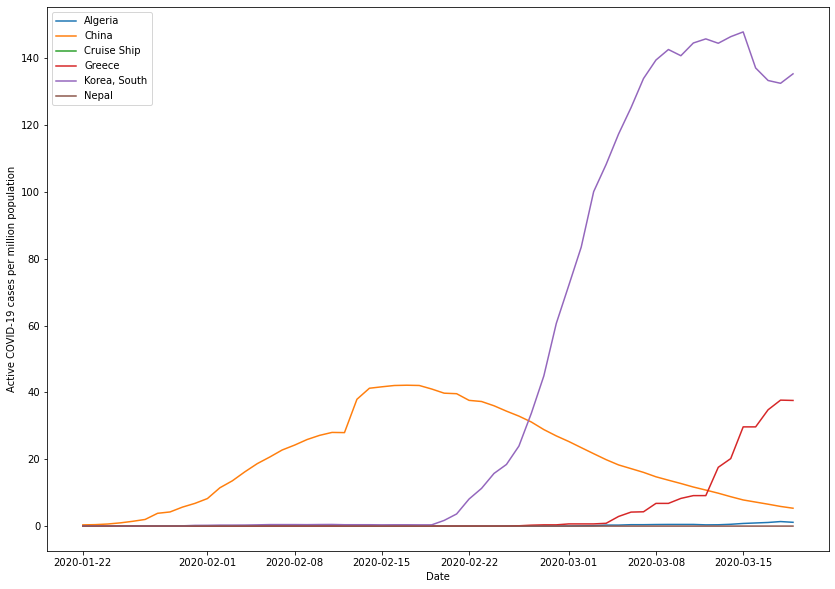

In [18]:
plt.figure(figsize=(14,10))
plt.xlabel("Date")
plt.ylabel("Active COVID-19 cases per million population")

for i in past_peak:
    plt.plot(covid_cases['active_per_million'][i], label=i)
    
plt.legend()

Following visual inspection:
- China and South Korea appear to be definitively passed their peak
- Greece may have passed their peak, but it's difficult to definitively say
- Algeria and Nepal both have small case numbers, which make it difficult to interpret the peak
- Cruise Ships are not a country

**What can you say about how long it takes for the outbreak to peak?**<br>
We can only confidently identify the peak with reasonable confidence in China, South Korea and Greece.

In [19]:
peaked = ['China', 'Korea, South', 'Greece']

days_to_peak = []

for i in peaked:
    peak_idx = covid_cases['active'][i][::-1].idxmax() 
    days_to_peak.append(covid_cases.loc[peak_idx, ('days_since_ten', i)])
    
mean_days_to_peak = np.mean(days_to_peak)
std_days_to_peak = np.std(days_to_peak)

print(f"Of the three countries to have peaked the peak occured {np.round(mean_days_to_peak, 2)} ± {np.round(std_days_to_peak, 2)} days after reaching 10 confirmed cases.")

Of the three countries to have peaked the peak occured 27.67 ± 12.71 days after reaching 10 confirmed cases.


**Based on the avilable data, can you estimate how long it takes a patient to recover? Does this vary by region or country? How confident can you be about these results?**

**Mitigation strategies are aimed at 'flattening' the outbreak, to reduce the strain on the health system. We discuss this in more detail in the concluding remarks below. For countries or regions that are far enough into their local outbreak, consider the number of active cases relative to the number of confirmed cases. Can you say anything about the effectiveness of their mitigation strategies?**

**In epidemiology, the case fatality rate (CFR) is the ratio of deaths from a certain disease to the total number of people diagnosed with this disease. The formula is straightforward once an epidemic has ended. However, while an epidemic is still ongoing—as is the case with the COVID-19 outbreak—this formula can be misleading if, at the time of analysis, the outcome is unknown for a non-negligible proportion of patients. One alternative is to estimate CFR as deaths / (deaths + recovered). What kind of assumptions is that making? If you use this formula, what range of values do you get? Does this vary over time?**

**With a disease like COVID-19 where the vast majority of cases are mild or even asymptomatic, the number of confirmed cases is going to be highly dependent on the testing strategy. Do you see any relationship between the number of cases and your estimated CFR values?**

### 5. Data visualisation

**For countries with at least 50 confirmed cases, plot the progression of the virus starting from day 0. Be mindful of the best ways to visualise this—normalised data, linear or log scale, etc.? Also pay attention to the specific parameters you use for creating your plots (remembering that default values are rarely the best choice).**

Lots of countries have >50 cases, the resulting plot is pretty messy, but it's what they're asking for....

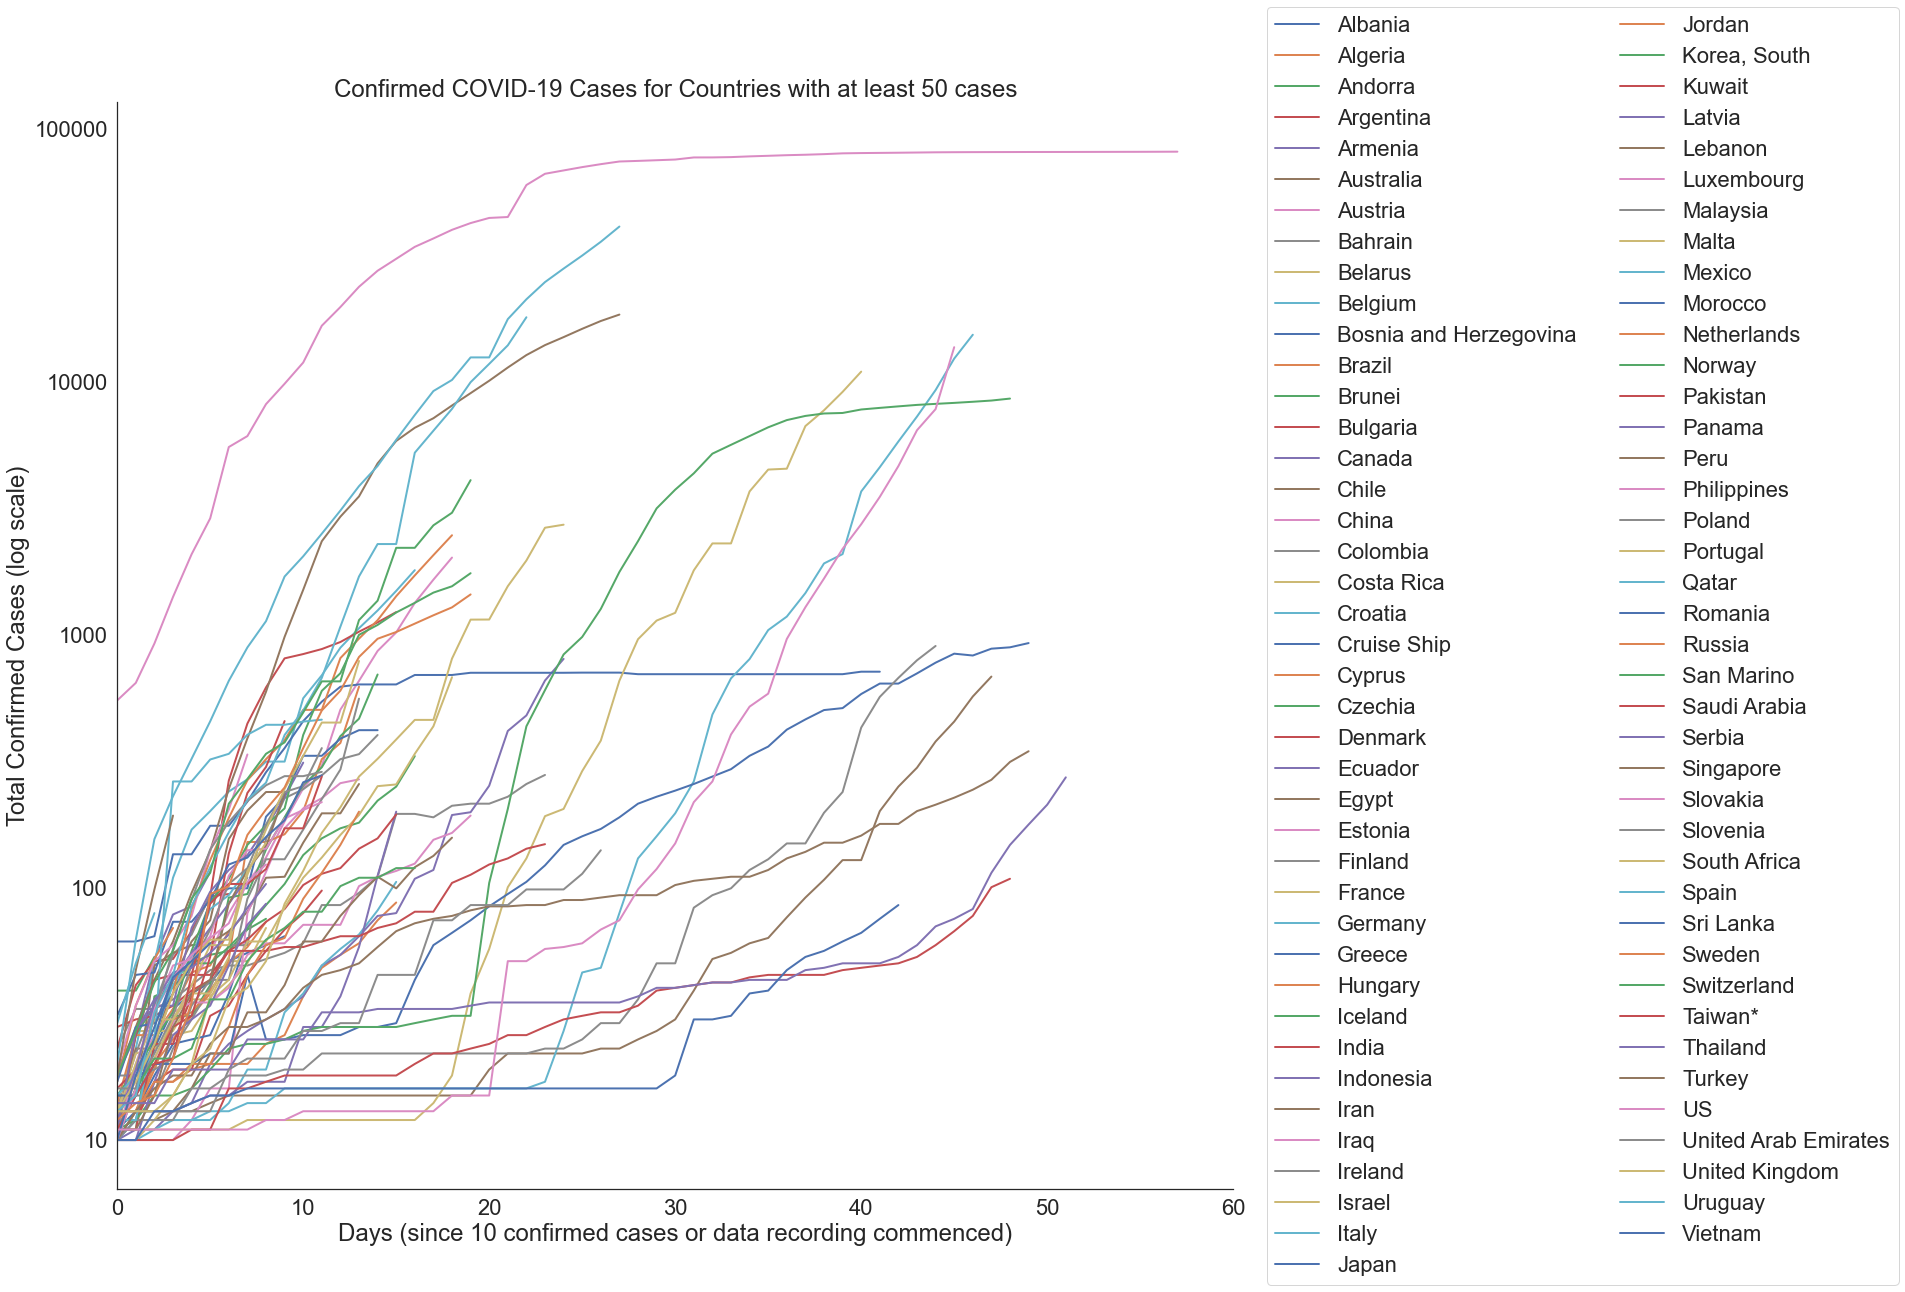

In [20]:
# Make a list of all countries that have more than 50 cases to date

at_least_50 = []

for country in covid_cases['confirmed'].columns:
    if covid_cases.loc[most_recent_date, ('confirmed', country)].item() > 50:
        at_least_50.append(country)
        
# Plot each country that has more than 50 cases to date

sns.set(style='white')
sns.set_context('notebook', font_scale=2)

fig, ax = plt.subplots(figsize=(20,20))

for country in at_least_50:
    # Temporary DF of only confirmed cases and days since for each country
    to_plot = covid_cases.loc[:,(['confirmed', 'days_since_ten'], country)].swaplevel(axis=1).droplevel('Country/Region', axis=1)
    # Plot only days after day 0 (10 cases)
    to_plot = to_plot[to_plot.days_since_ten >= 0]
    ax.plot(to_plot['days_since_ten'], to_plot['confirmed'], linewidth=2, label=country)

# Log scale for the y axis (makes it more interpretable between countries early in the pandemic)
ax.set_yscale('log')
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.set_xlim(0,60)

# Title and labels
ax.set_ylabel("Total Confirmed Cases (log scale)")
ax.set_xlabel("Days (since 10 confirmed cases or data recording commenced)")

ax.set_title("Confirmed COVID-19 Cases for Countries with at least 50 cases")

# Legend
ax.legend(ncol=2, loc='center left', bbox_to_anchor=(1.02, 0.5))

# Aesthetics
sns.despine()

plt.show()

**Optional: For each of the last five weeks, create a global map showing the rate of increase in the number of confirmed cases over that week. Create similar maps for the rate of increase in the number of active cases.**

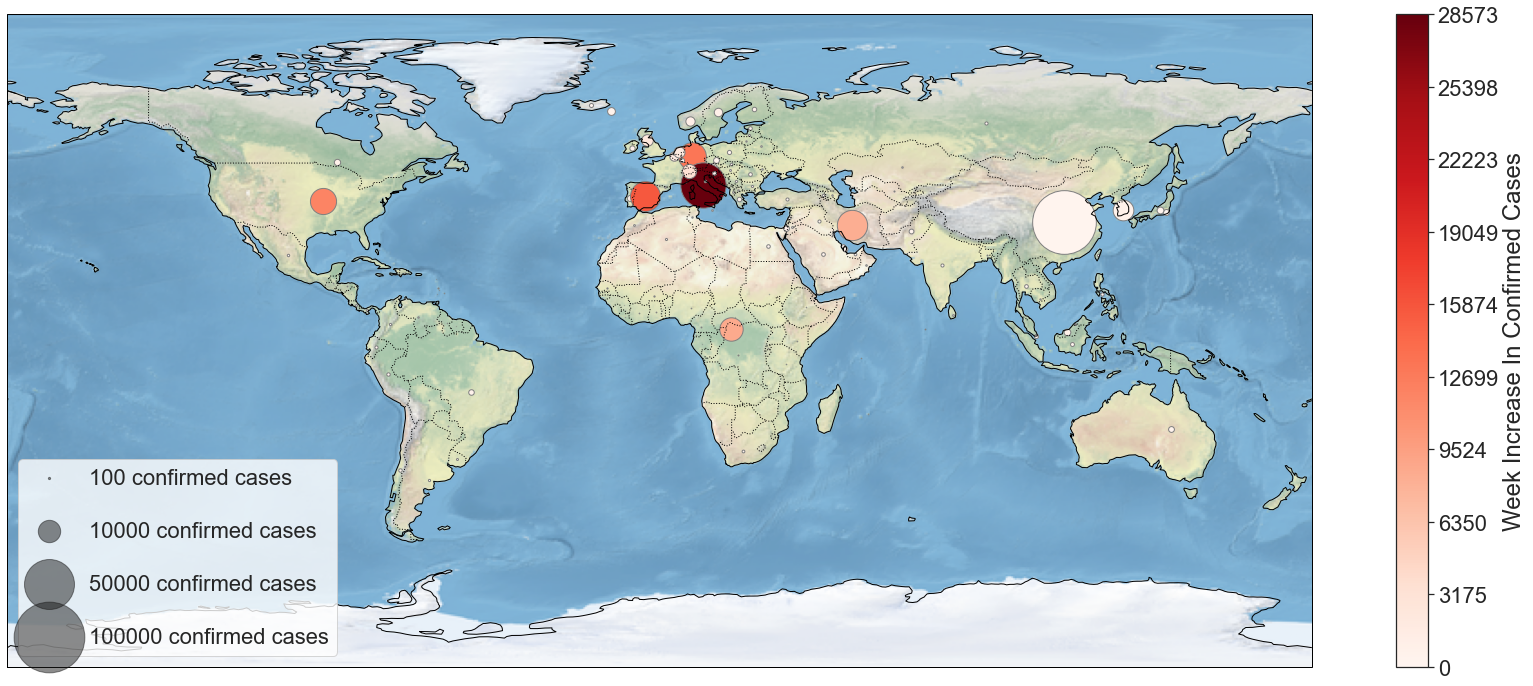

In [33]:
fig = plt.figure(figsize=(30,12))

ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.stock_img()
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.COASTLINE)

data_crs = ccrs.PlateCarree()

week_change_list = []
week_confirmed_list = []

for country in covid_cases['confirmed'].columns:
    week_end = most_recent_date
    week_start = most_recent_date - timedelta(days=7)
    week_end_confirmed = covid_cases.loc[week_end, ('confirmed', country)].item()
    week_start_confirmed = covid_cases.loc[week_start, ('confirmed', country)].item()
    week_change_list.append(week_end_confirmed - week_start_confirmed)
    week_confirmed_list.append(week_end_confirmed)

mini, maxi = min(week_change_list), max(week_change_list)
norm=plt.Normalize(mini,maxi)

for country in covid_cases['confirmed'].columns:
    lat, long = coords.loc[country, 'Lat'], coords.loc[country, 'Long']
    week_end = most_recent_date
    week_start = most_recent_date - timedelta(days=7)
    week_end_confirmed = covid_cases.loc[week_end, ('confirmed', country)].item()
    week_start_confirmed = covid_cases.loc[week_start, ('confirmed', country)].item()
    week_change = week_end_confirmed - week_start_confirmed
    ax.scatter(long, lat, transform=data_crs,
              c=week_change, s=(week_end_confirmed/20),
              cmap='Reds', alpha=1, edgecolors='grey',
              norm=norm)
    #ax.text(long, lat, country)
    
sm = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=mini, vmax=maxi))
sm._A = []
cb = plt.colorbar(sm, label='Week Increase In Confirmed Cases')
cb.set_ticks(np.linspace(mini, maxi, 10))

# make legend with dummy points
for a in [100, 10000, 50000, 100000]:
    plt.scatter([], [], c='k', alpha=0.5, s=a/20,
                label=str(a) + ' confirmed cases')
plt.legend(scatterpoints=1, frameon=True,
           labelspacing=1.5, loc='lower left')

plt.show()

**Optional: Create a map to visualise the results of your 'mitigation' analysis (fourth question of the previous section).**

### 6. Concluding remarks